# Working with data

### In PySprint currently 4 different evaluating methods are supported: 
* Minimum - maximum method
* Cosine fit method
* Stationary phase point method
* Fouier-transform method 

PySprint API provides a basic *Dataset* class for all of the methods.

Let's say you want to use the 
## Cosine function fit method
(CFF for short) on a spectrogram. First, let's generate data.  

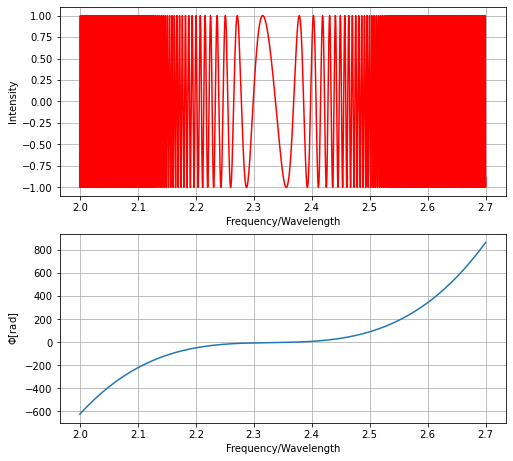

In [16]:
%matplotlib inline

from pysprint import Generator, CosFitMethod

myspectr = Generator(2, 2.7, 2.355, delay=100, GDD=2500, TOD=100000, normalize=True, resolution=0.01)
myspectr.generate_freq()
myspectr.phase_graph()

The fastest way to construct from `pysprint.Generator` is the following:

In [17]:
mycosfit = CosFitMethod(*myspectr.data)

Cosine fit method is really sensitive to initial parameters. Most of the time leaving all parameters default will result to inaccurate fitting. Parameters can be accessed via *object.params*. It is always a 8-length list with the following parameters: $$[c_0, c_1, b_0, b_1, b_2, b_3, b_4, b_5]$$

$$ c_0 + c_1 \cdot cos (b_0 + b_1\cdot x + b_2\cdot x^2+ b_3\cdot x^3+ b_4\cdot x^4+ b_5\cdot x^5)$$

In this example, I will modify the defaults:
We assume there's no higher order dispersion than TOD and we will try to fit the following:
$$\ c_0 + c_1 \cdot cos (b_0 + b_1\cdot x + b_2\cdot x^2 + b_3\cdot x^3)$$
Do achieve it, CosFitMethod has built-in methods:

In [18]:
#guess the dispersion
mycosfit.guess_GD(100)
mycosfit.guess_GDD(2500)
mycosfit.guess_TOD(100000)
#restrict maximum dispersion order (make sure you call this in the end, otherwise it can be overwritten)
mycosfit.set_max_order(3)

If everything's set, we are ready to use the *calculate* method. (By the way, all methods work like this.)

In [19]:
#by calling the calculate method, the parameters immediately printed and also returned
dispersion, dispersion_std, fit_report = mycosfit.calculate(reference_point=2.355)

GD = 100.00000 ± 0.00000 fs^1
GDD = 2500.00000 ± 0.00000 fs^2
TOD = 100000.00000 ± 0.00000 fs^3
FOD = 0.00000 ± 0.00000 fs^4
QOD = 0.00000 ± 0.00000 fs^5


To see how good the fit was:

r^2 = 1.0


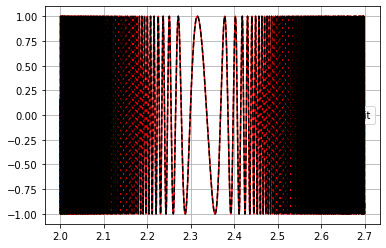

In [20]:
mycosfit.plot_result()

Let's generate another spectrogram for:
## Fourier method
It doesn't require the spectrum to be normalized and we need higher delay. 

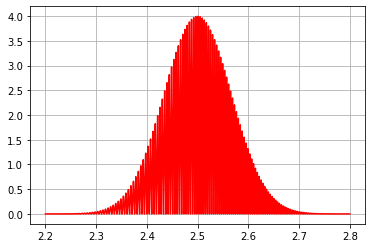

In [23]:
h = Generator(2.2, 2.8, 2.5, delay = 1500, GDD = 2000, FOD = -100000, pulse_width=25, resolution = 0.01)
h.generate_freq()

from pysprint import FFTMethod

myfourier = FFTMethod(*h.data)
myfourier.show()

We will perform IFFT, then cut the valuable part and FFT back:

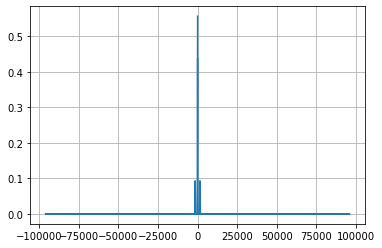

In [24]:
myfourier.ifft()
myfourier.show()

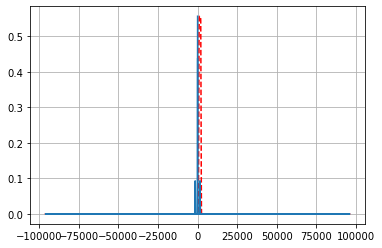

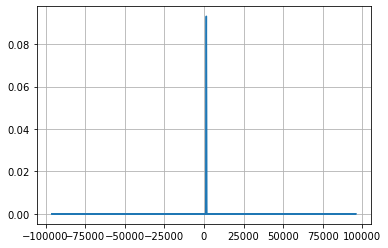

In [25]:
myfourier.window(1500, 1490, window_order = 8)
myfourier.apply_window()
myfourier.show()

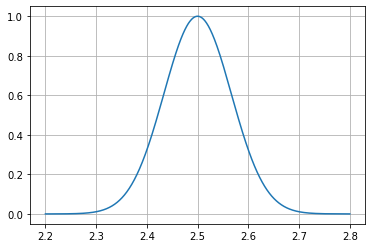

In [26]:
myfourier.fft()
myfourier.show()

Now, we specify the fit order and reference_point, then calculate:

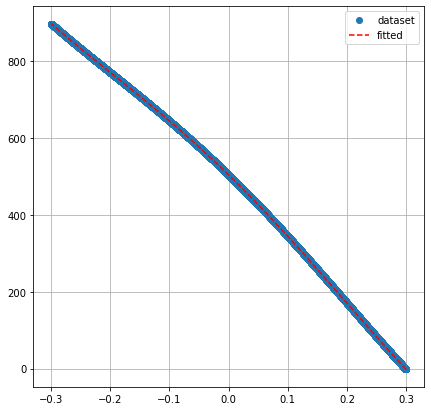

GD = -1500.04662 ± 0.00350 fs^1
GDD = -1999.72297 ± 0.06333 fs^2
TOD = 7.26760 ± 0.35677 fs^3
FOD = 99945.05624 ± 9.43835 fs^4
QOD = 0.00000 ± 0.00000 fs^5


In [28]:
dispersion, dispersion_std, fit_report = myfourier.calculate(order=4, reference_point=2.5, show_graph=True)

## Minimum-maximum method:

For minimum maximum method we need a good peak detection algorithm. PySprint has some built-in tools for that, but also you can manually pass min and max x values to the function.

We will use the first dataset for this method. 

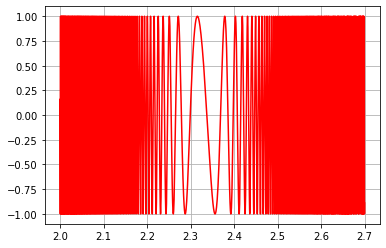

In [30]:
from pysprint import MinMaxMethod

mymm = MinMaxMethod(*myspectr.data)
mymm.show()

We will use the *detect_peak* method for now.

In [31]:
max_x, max_y, min_x, min_y = mymm.detect_peak(pmax = 0.01, pmin = 0.01, threshold = 0.6)

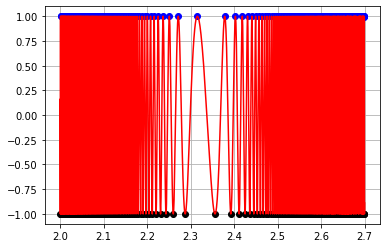

In [32]:
#plotting the mins as black dots, maxs as blue dots
mymm.plotwidget.plot(max_x, max_y, 'bo')
mymm.plotwidget.plot(min_x, min_y, 'ko')
mymm.show()

For the Minimum - maximum method we need the x coordinates. We pass them to the created class, then we use the *calculate* method.
The maximums can be passed via *object.xmax*, minimums via *object.xmin*. (We don't need the y coordinates for calculation, that's only for plotting.)

In [33]:
mymm.xmax = max_x
mymm.xmin = min_x

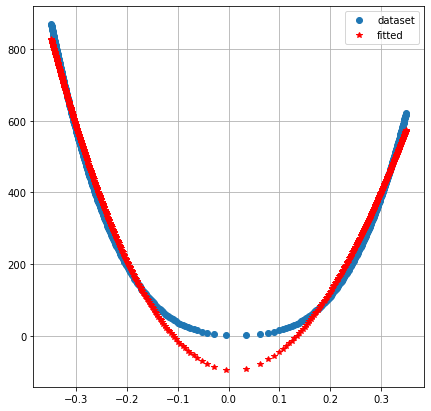

GD = -125.65015 ± 15.81887 fs^1
GDD = 12984.47357 ± 74.25401 fs^2
TOD = -11583.25637 ± 1039.73769 fs^3
FOD = 0.00000 ± 0.00000 fs^4
QOD = 0.00000 ± 0.00000 fs^5


In [35]:
dispersion, disperson_std, fit_report = mymm.calculate(reference_point=2.35, order=3, show_graph=True)

Lastly: 
## Stationary phase point method
(SPP for short). This method is not quite good as in the GUI: Basically it's a curve fitting function which calculates dispersion from the parameters.

In [43]:
from pysprint import SPPMethod

#always use the 'from_raw' constructor, it allows to pass matching pairs of data (unlike in the GUI)
dlys = [1,2,3,4,5,6]
fr = [10,20,30,40,50,60]
SPPMethod.calculate_from_raw(fr, dlys, reference_point=2, order=2)

([0.19999999826125517, 0.1000000001439262, -4.361400129937465e-12, 0, 0],
 [0, 0, 0, 0, 0])